- set up git (add your name and email once) and pull the repo

In [14]:
# change wd to team working directory
import os
#os.chdir('/scratch/ws/gpu16-d3hack2019-DeepHydro/')
#!git config --global user.name "Lennart Schmidt"
#!git config --global user.email "lennart.schmidt@ufz.de"
#!git pull

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import keras
import numpy as np
import os, sys
import pandas as pd
from skimage.external import tifffile
import skimage
skimage.__version__

Using TensorFlow backend.


'0.15.0'

- import **deephydro module** with networks, losses and metrics

In [7]:
%load_ext autoreload
%autoreload 2
module_folder = os.path.abspath('../src')
#module_folder = 'src/'
if module_folder not in sys.path:
    sys.path.append(module_folder)
import deephydro

#from deephydro.utils import limit_gpu_memory
#limit_gpu_memory()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data import

- paths

In [18]:
data_folder = '../Data/Npy'
data_disc = '01_discharge_training.csv'
data_prec = '01_prec_training.npy'
data_temp = '01_temp_training.npy'
data_elev = '01_dem.npy'
data_mask = '01_mask.npy'

- read output data

In [16]:
from deephydro.data import load_csv_data
df = load_csv_data(data_folder, data_disc)
df.head()

Unnamed: 0        Time      Q  DOY  DiffToMidSummer      FDOY
0       27455  1950-01-01  558.0    1         0.002740  0.002732
1       27456  1950-01-02  547.0    2         0.005479  0.005464
2       27457  1950-01-03  541.0    3         0.008219  0.008197
3       27458  1950-01-04  541.0    4         0.010959  0.010929
4       27459  1950-01-05  564.0    5         0.013699  0.013661

In [17]:
def plot_streamflow(df, n_labels=10):
    fig, ax = plt.subplots()
    ax.plot(df['Time'], df['Q'])
    ax.xaxis.set_major_locator(plt.MaxNLocator(n_labels)) # limit number of dates on x axis
    fig.autofmt_xdate() # rotate data labels
    plt.show()

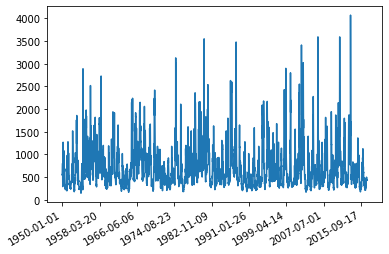

In [18]:
plot_streamflow(df)

### Load data directly as .npy files

In [19]:
from deephydro.data import load_from_numpy
prec = load_from_numpy(data_folder, data_prec)
temp = load_from_numpy(data_folder, data_temp)
elev = load_from_numpy(data_folder, data_elev)
mask = load_from_numpy(data_folder, data_mask)



In [20]:
print(elev.shape)
print(temp.shape)
print(prec.shape)
print(mask.shape)

(53, 66)
(19358, 53, 66)
(19358, 53, 66)
(53, 66)


In [21]:
def plot_frame(temp:np.array, prec:np.array, mask:np.array, df:pd.DataFrame, frame:int, limits:tuple=None):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    im_t = np.ma.masked_array(temp[frame], mask=mask)
    im_p = np.ma.masked_array(prec[frame], mask=mask)
    
    ax[0].set_title('Temperature')
    if limits is None:
        cb1 = ax[0].imshow(im_t)
    else:
        cb1 = ax[0].imshow(im_t, vmin=limits[0], vmax=limits[1])
    fig.colorbar(cb1, ax=ax[0], orientation='horizontal')

    ax[1].set_title('Precipitation')
    if limits is None:
        cb2 = ax[1].imshow(im_p)
    else:
        cb2 = ax[1].imshow(im_p, vmin=limits[2], vmax=limits[3])
    fig.colorbar(cb2, ax=ax[1], orientation='horizontal')
    
    for a in ax: a.axis('off')
        
    plt.show()

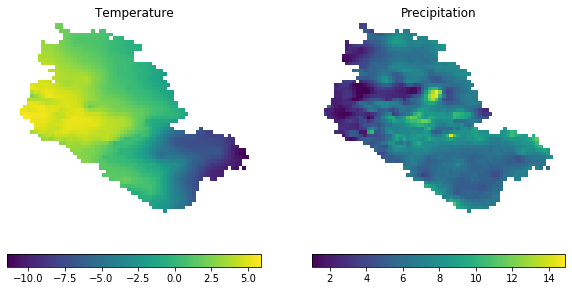

In [22]:
plot_frame(temp, prec, mask, df, frame=11)

# Data preparation

- standardize output data (`y`)

In [78]:
def standardize(data:np.array, return_moments=False):
    mean = np.mean(data)
    std = np.std(data)
    if return_moments:
        return (data-mean)/std, mean, std
    else:
        return (data-mean)/std

Y_MEAN = 704.088
Y_STD  = 439.004
Shape of y =  (24472,)


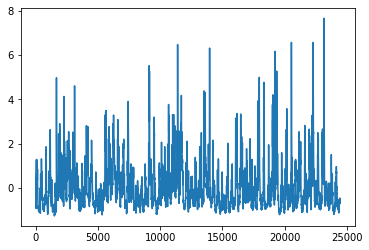

In [79]:
y, Y_MEAN, Y_STD = standardize(df['Q'].values, return_moments=True)
print(f'Y_MEAN = {Y_MEAN:.3f}')
print(f'Y_STD  = {Y_STD:.3f}')
print('Shape of y = ', y.shape)

# plot data
plt.plot(y)

- Split into training + validation and stack temp+prec
- Note that validation is called "test" (for not having to change the whole code)

In [69]:
from deephydro.data import split_train_validation
# stack inputs
x = np.stack([temp, prec], axis=-1)
print('Shape of x = ', x.shape)
x_train, x_test, y_train, y_test = split_train_validation(x, df.Q ,validation_fraction=0.2,validation_first=False)

Shape of x =  (19358, 53, 66, 2)


In [70]:
print('Shape of x_train = ', x_train.shape)
print('Shape of y_train = ', y_train.shape)
print('Shape of x_test  = ', x_test.shape)
print('Shape of y_test  = ', y_test.shape)


Shape of x_train =  (15487, 53, 66, 2)
Shape of y_train =  (15487,)
Shape of x_test  =  (3871, 53, 66, 2)
Shape of y_test  =  (3871,)


- standardize training set, then use the derived parameters to standardize val

In [71]:
from deephydro.data import standardize
y_train, Y_MEAN, Y_STD = standardize(y_train, return_moments=True)
print(f'Y_MEAN = {Y_MEAN:.3f}')
print(f'Y_STD  = {Y_STD:.3f}')
print('Shape of y = ', y_train.shape)

y_test = (y_test-Y_MEAN)/Y_STD

# plot data
#plt.plot(y_train)


Y_MEAN = 715.437
Y_STD  = 426.762
Shape of y =  (15487,)


* Same on inputs
* Use np.ma.masked array or doesnt that matter?
* Are P + T in other order than specified in stack()?

In [72]:
# precipitation
x_train[:,:,:,0], X_P_MEAN, X_P_STD = standardize(x_train[:,:,:,0], return_moments=True)
# temperature
x_train[:,:,:,1], X_T_MEAN, X_T_STD = standardize(x_train[:,:,:,1], return_moments=True)

# validation data
x_test[:,:,:,0] = (x_test[:,:,:,0]-X_P_MEAN)/X_P_STD
x_test[:,:,:,1] = (x_test[:,:,:,1]-X_T_MEAN)/X_T_STD

In [73]:
print(f'X_T_MEAN = {X_T_MEAN:.3f}')
print(f'X_T_STD  = {X_T_STD:.3f}')
print(f'X_P_MEAN = {X_P_MEAN:.3f}')
print(f'X_P_STD  = {X_P_STD:.3f}')



X_T_MEAN = 0.798
X_T_STD  = 2.735
X_P_MEAN = 3.792
X_P_STD  = 6.688


## Data generator

To sample image sequences, we do not store of all possible image sequences to memory. This would imply storing a lot of overlapping (=redundant) data.

Instead, we use a generator to generate a batch of random sequences. We could build a simple generator function using the `yield` statement, but to exploit parallel processing during batch generation, we will extend the `keras.utils.Sequence` class. 

In [74]:
# length of image sequence
n_frames = 30
# number of GPUs
n_gpus = 4
# adjust this to available GPU memory (VRAM)
batch_size = 92*n_gpus

# use day of year ?
day_of_year = False
# forecasting ?
forecasting = False
# uncertainty estimation ?
uncertainty = False



In [11]:
from deephydro.generator import ImageSequenceGenerator
generator_train = ImageSequenceGenerator(data=x_train, labels=y_train, batch_size=batch_size, n_frames=n_frames)
generator_test  = ImageSequenceGenerator(data=x_train, labels=y_train, batch_size=batch_size, n_frames=n_frames)

NameError: name 'x_train' is not defined

In [86]:
batch = generator_train.__getitem__(0)
print(f'Shape of batch_x = {batch[0].shape}')
print(f'Shape of batch_y = {batch[1].shape}')


Shape of batch_x = (368, 30, 53, 66, 2)
Shape of batch_y = (368,)


In [22]:
#batch[0][0][1]

# Model

- load model
- predicts the streamflow from a short sequence of temperature and precipitation...

In [87]:
input_shape = (n_frames, *x_train.shape[1:])
from deephydro import networks
model = networks.nowcasting_model(input_shape, dayofyear=day_of_year)
#model = networks.get_conv_lstm_model(input_shape)
model.summary()

W0909 20:40:22.523758 35184372371248 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-powerai/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0909 20:40:22.574041 35184372371248 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-powerai/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0909 20:40:22.574925 35184372371248 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-powerai/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0909 20:40:22.990544 35184372371248 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-powerai/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_

256
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          (None, 30, 53, 66, 2)     0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 30, 26, 32, 16)    10432     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 26, 32, 16)    64        
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 30, 12, 15, 32)    55424     
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 12, 15, 32)    128       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 30, 5, 7, 64)      221440    
_________________________________________________________________
batch_normalization_3 (Batch (None, 30, 5, 7, 64)      256       
______

- compile model: loss, optimizer and metrics

In [88]:
from keras import optimizers
from deephydro.losses import mse, logcosh, gauss
from deephydro.metrics import ccc

def build_model(model, 
                loss=logcosh,
                metrics=ccc,
                optimizer=optimizers.Adam(lr=1e-3), 
                n_gpus:int=1):
    if n_gpus > 1:
        from keras.utils import multi_gpu_model
        parallel_model = multi_gpu_model(model, gpus=n_gpus)
        parallel_model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])
        return parallel_model
    else:
        model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])
        return model


# Training

In [89]:
n_epochs = 20

In [92]:
from deephydro.utils import checkpointer, early_stopping, reduce_learning_rate
#callbacks = [checkpointer('../output/model.h5'), early_stopping(), reduce_learning_rate()]
callbacks = [checkpointer('output/model.h5'), early_stopping(), reduce_learning_rate()]

In [93]:
if n_gpus > 1:
    parallel_model = build_model(model, loss=logcosh, n_gpus=n_gpus)
    parallel_model.summary()
    history = parallel_model.fit_generator(
                              # training
                              generator=generator_train,
                              steps_per_epoch=len(x_train)//batch_size,
                              epochs=n_epochs,
                              # validation
                              validation_data=generator_test,
                              validation_steps=len(x_test)//batch_size,
                              # callbacks
                              callbacks=callbacks,
                              # CPU parallelism 
                              #use_multiprocessing=False,
                              #workers=3, # if too large, you'll get CPU memory issues (job gets killed)
                              #max_queue_size=10
                              )
else:
    model = build_model(model, loss=logcosh, n_gpus=n_gpus)
    model.summary()
    history = model.fit_generator(
                              # training
                              generator=generator_train,
                              steps_per_epoch=len(x_train)//batch_size,
                              epochs=n_epochs,
                              # validation
                              validation_data=generator_test,
                              validation_steps=len(x_test)//batch_size,
                              # callbacks
                              callbacks=callbacks,
                              # CPU parallelism 
                              #use_multiprocessing=False,
                              #workers=12,
                              #max_queue_size=10
                              )

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             (None, 30, 53, 66, 2 0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 30, 53, 66, 2 0           images[0][0]                     
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 30, 53, 66, 2 0           images[0][0]                     
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 30, 53, 66, 2 0           images[0][0]                     
__________________________________________________________________________________________________
lambda_8 (

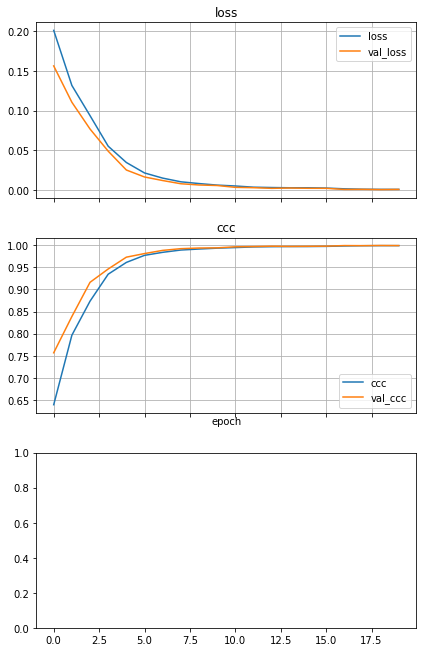

In [94]:
from deephydro.visualization import plot_history
plot_history(history)

# Predict

In [96]:
from deephydro.utils import predict
batch = generator_test.__getitem__(0)
im = batch[0][0]
gt = batch[1][0] * Y_STD + Y_MEAN
y_pred = predict(model, image=im, y_mean=Y_MEAN, y_std=Y_STD)
print(f'Predicted: {y_pred:.2f}, True: {gt:.2f}, Error: {abs(y_pred-gt):.2f}')

Predicted: 431.15, True: 412.00, Error: 19.15


In [97]:
from deephydro.utils import predict_batch
x, y = predict_batch(model, generator=generator_test, n_samples=5000, y_mean=Y_MEAN, y_std=Y_STD)

0 / 5000
368 / 5000
736 / 5000
1104 / 5000
1472 / 5000
1840 / 5000
2208 / 5000
2576 / 5000
2944 / 5000
3312 / 5000
3680 / 5000
4048 / 5000
4416 / 5000
4784 / 5000


(5000,)
(5000,)
(5000,)
(5000,)


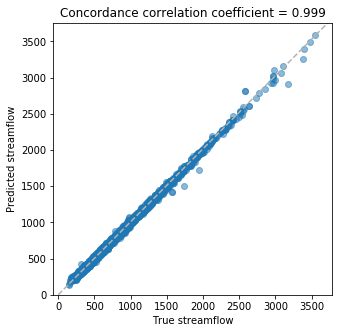

In [98]:
from deephydro.visualization import plot_correlation
plot_correlation(x, y)

# Saliency map

- using a variant of `DeepLIFT` called `DeepShap` based on Shapley values and implemented in the package [`shap`](https://github.com/slundberg/shap)


```
conda install -c conda-forge shap
pip install tqdm --upgrade # I needed to upgrade tqdm (progress bar)
```

In [99]:
# get a batch of images
batch = generator_test.__getitem__(0)
# select a single image
im = batch[0][123]

In [100]:
from deephydro.utils import saliency_map
shap = saliency_map(model, generator=generator_test, image=im)
print(shap.shape)

ModuleNotFoundError: No module named 'shap'

In [ ]:
from deephydro.visualization import plot_saliency_map
plot_saliency_map(image=im, shap_values=shap, mask=mask)